**Загрузка данных через API kaggle**

In [1]:
!pip install kaggle

In [0]:
import os
user = ''
key = ''
 
if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c airbus-ship-detection

  0% 0.00/274k [00:00<?, ?B/s]
100% 274k/274k [00:00<00:00, 51.0MB/s]
100% 18.0M/18.0M [00:00<00:00, 15.4MB/s]

100% 2.12G/2.12G [01:16<00:00, 49.9MB/s]
100% 2.12G/2.12G [01:16<00:00, 29.9MB/s]
100% 26.4G/26.4G [21:09<00:00, 22.3MB/s]
100% 26.4G/26.4G [21:09<00:00, 22.3MB/s]


In [5]:
!ls

bestfo.h5		   test.zip
best_xceptoion.h5	   train
dd.csv			   train_labels.csv
fddd.csv		   train_labels.csv.zip
last_xception.h5	   train_ship_segmentations_v2.csv.zip
sample_data		   train_v2.zip
sample_submission.csv	   train.zip
sample_submission.csv.zip  tt.csv
sample_submission_v2.csv   v.h5
test			   xception.json
test_v2.zip


In [0]:
!unzip train_v2.zip -d train

In [0]:
!unzip test_v2.zip -d test

In [0]:
!unzip train_ship_segmentations_v2.csv.zip

In [0]:
!unzip sample_submission_v2.csv

In [0]:
!ls

**Изучаем данные**

In [0]:
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

In [0]:
train_df = pd.read_csv('train_ship_segmentations_v2.csv')
sample_submission = pd.read_csv('sample_submission_v2.csv')

In [0]:
train_df.columns

Index(['ImageId', 'EncodedPixels'], dtype='object')

In [0]:
train_df.head(6)

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...

In [0]:
train_df.shape

(231723, 2)

In [0]:
## Количество уникальных значений rle
sum(train_df['EncodedPixels'].value_counts())

81723

In [0]:
## Количество не сегментированых снимков в датасете
train_masks[train_masks['EncodedPixels'].isna() == True]

ImageId EncodedPixels
0       00003e153.jpg           NaN
1       0001124c7.jpg           NaN
8       0001b1832.jpg           NaN
20      0002d0f32.jpg           NaN
21      000303d4d.jpg           NaN
23      00052ed46.jpg           NaN
27      00057a50d.jpg           NaN
28      000592296.jpg           NaN
33      0007b8229.jpg           NaN
34      000805313.jpg           NaN
35      000811bb6.jpg           NaN
36      0008d6216.jpg           NaN
37      000913daf.jpg           NaN
38      000952d51.jpg           NaN
39      000969125.jpg           NaN
40      0009a46e1.jpg           NaN
41      000a4d4fd.jpg           NaN
42      000aed819.jpg           NaN
43      000baef0c.jpg           NaN
44      000bd9ac4.jpg           NaN
45      000c150b0.jpg           NaN
46      000c34352.jpg           NaN
47      000d26c17.jpg           NaN
49      000db3e62.jpg           NaN
50      000e37fc6.jpg           NaN
52      000e64855.jpg           NaN
53      000f1f959.jpg           NaN
54      000f7e728.jpg           NaN
55      000f7f2fd.jpg           NaN
57      00104f16f.jpg           NaN
...               ...           ...
231685  fff509e15.jpg           NaN
231687  fff60f4bc.jpg           NaN
231689  fff75d91a.jpg           NaN
231691  fff8125de.jpg           NaN
231692  fff89e163.jpg           NaN
231693  fff8ced35.jpg           NaN
231695  fff9395dc.jpg           NaN
231696  fff998ae9.jpg           NaN
231697  fff9aa012.jpg           NaN
231698  fffa15273.jpg           NaN
231699  fffa44607.jpg           NaN
231700  fffa5960e.jpg           NaN
231701  fffa80c97.jpg           NaN
231702  fffa926c8.jpg           NaN
231703  fffb2924f.jpg           NaN
231704  fffb36a47.jpg           NaN
231705  fffbb804d.jpg           NaN
231706  fffc0ade1.jpg           NaN
231707  fffc12f8c.jpg           NaN
231708  fffc6b811.jpg           NaN
231710  fffcd0cf7.jpg           NaN
231711  fffcda6d6.jpg           NaN
231715  fffe4c385.jpg           NaN
231716  fffe4fa23.jpg           NaN
231717  fffe646cf.jpg           NaN
231718  fffedbb6b.jpg           NaN
231719  ffff2aa57.jpg           NaN
231720  ffff6e525.jpg           NaN
231721  ffffc50b4.jpg           NaN
231722  ffffe97f3.jpg           NaN

[150000 rows x 2 columns]

Всего на 82k снимках из 232k присутствует(сегментирована) морская посудина,остальные 150k снимков не размечены.

**Визуализируем несколько снимков**


---
***Посмотрим на изображения на которых присутствует хотя бы один корабль***


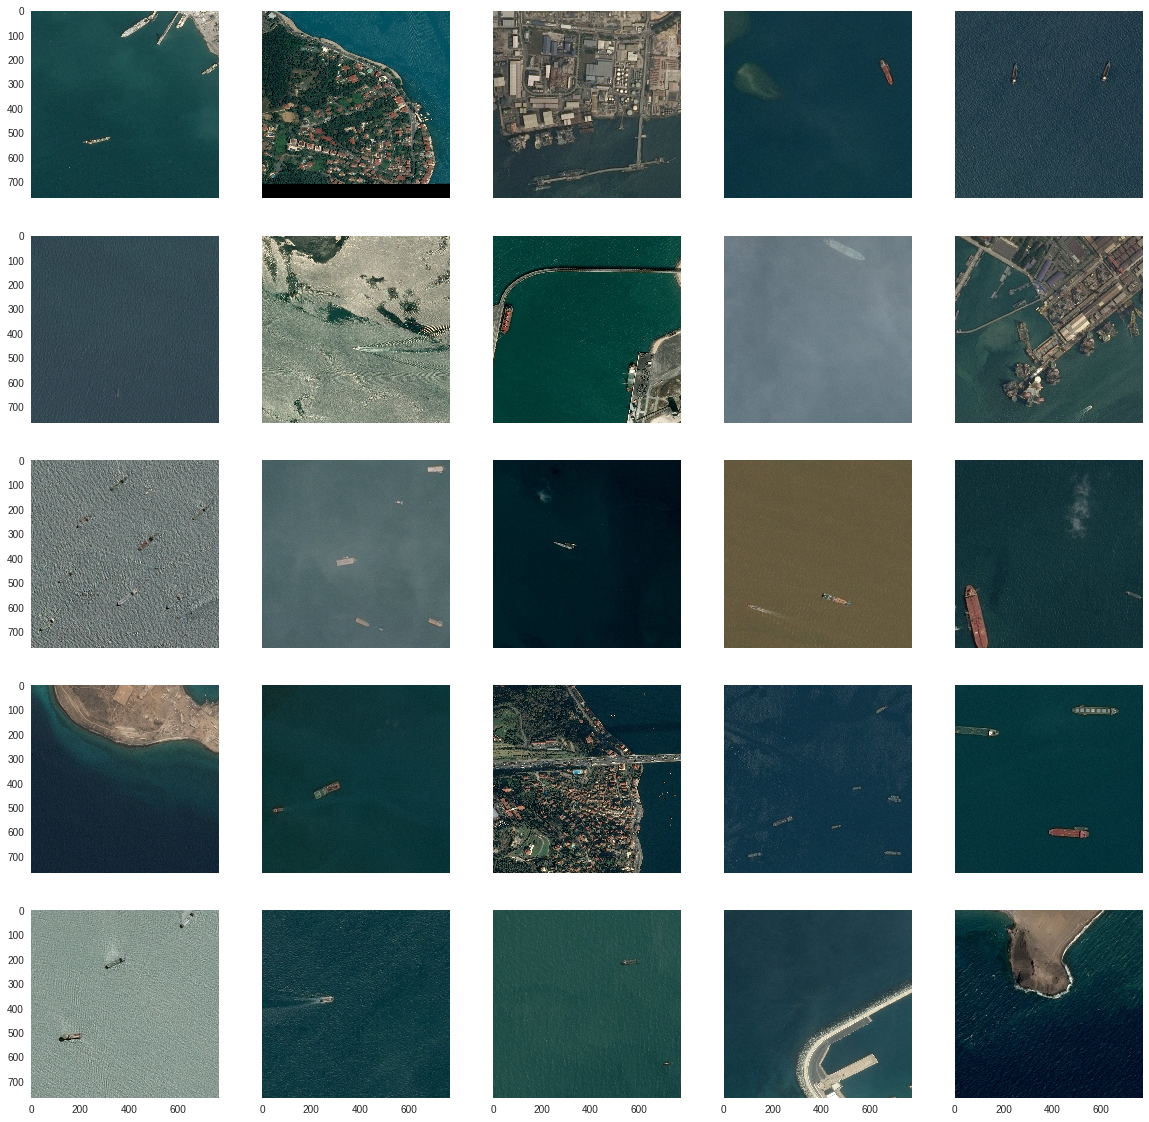

In [0]:
samples = train_df[~train_df['EncodedPixels'].isna()].sample(25)

fig, ax = plt.subplots(5, 5,sharex='col', sharey='row')
fig.set_size_inches(20, 20)

for i, idimg in enumerate(samples['ImageId']):
    col = i % 5
    row = i // 5
    
    path = 'train/{}'.format(idimg)
    img = cv2.imread(path)
    
    ax[row, col].imshow(img[...,[2,1,0]])


**Посмотрим на изображения на которых нет ни одного коробля**

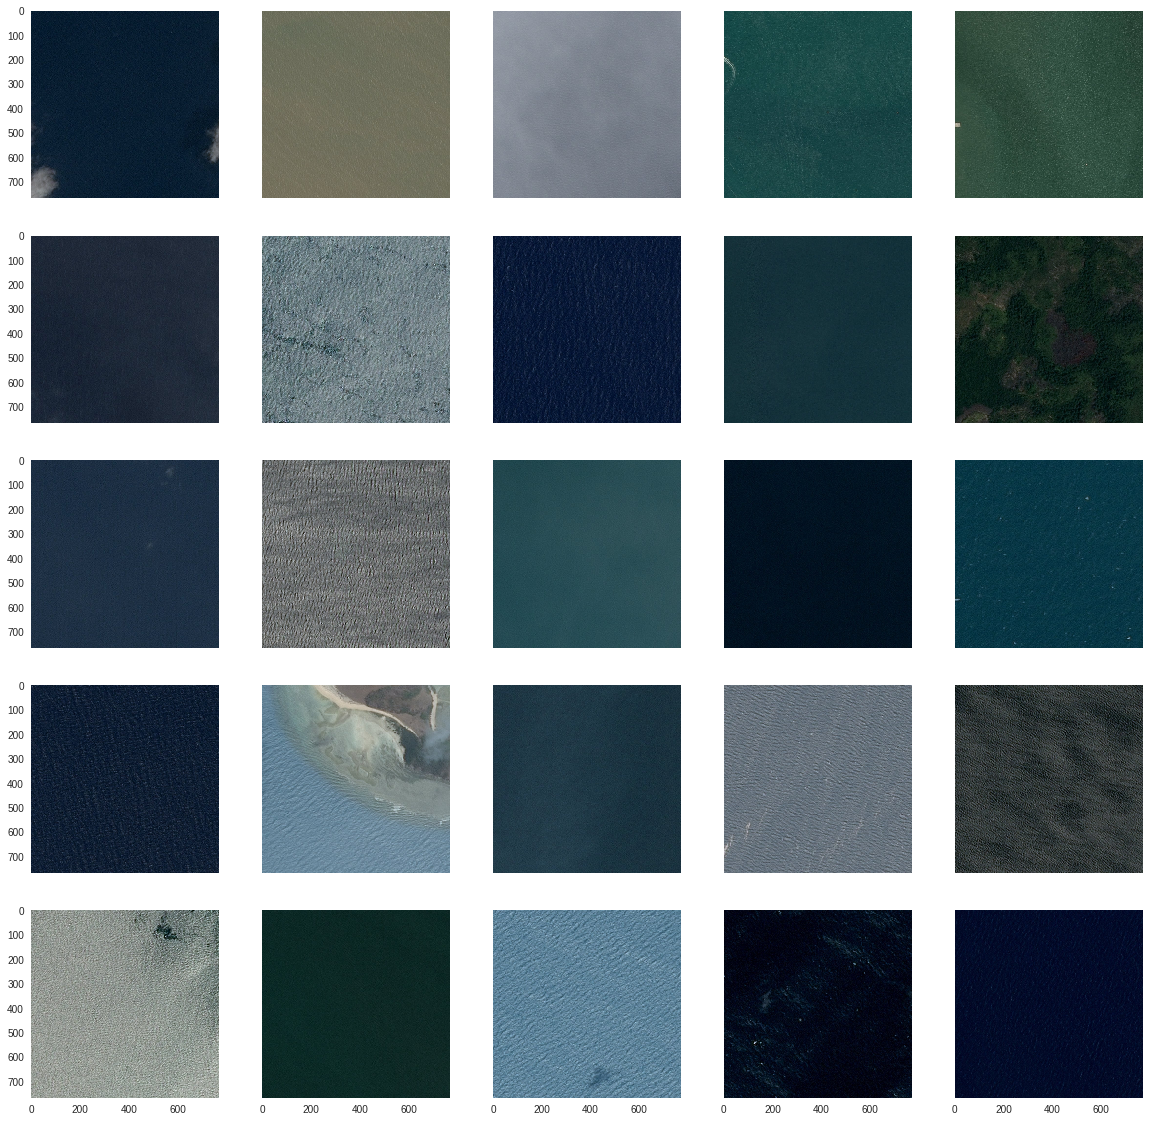

In [0]:
samples = train_df[train_df['EncodedPixels'].isna()].sample(25)

fig, ax = plt.subplots(5, 5,sharex='col', sharey='row')
fig.set_size_inches(20, 20)

for i, idimg in enumerate(samples['ImageId']):
    col = i % 5
    row = i // 5
  
    path = 'train/{}'.format(idimg)
    img = cv2.imread(path)
    
    ax[row, col].imshow(img[...,[2,1,0]])

**Понимание run-length encoding**

---

**Наложим  rle маски на изображения где присутствует хотя бы один корабль,после чего  отрисуем изображения**

In [13]:
# Очищаем данные от Nan и удаляем индекс
df = pd.read_csv("train_ship_segmentations_v2.csv", index_col=0).dropna()
df.head()

EncodedPixels
ImageId                                                         
000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...

Кодировка **RLE** представляет собой простое представление форм в 2d изображениях. В данном случае численно кодируются некоторые внешне напоминающие прямоугольники соответствующие кораблям на тех снимках где они присутствуют.

Закодированная строка выглядит следующим образом: **start** , **length**, **starth** , **length** ..., где каждая пара (**start** , **length**) рисует линию пикселей **lenght**, начиная с позиции **start**. Начальная позиция(**start**), в свою очередь, является индексом 1-d массива одинаковых последовательностей, получившегося в результате кодировки пикселей изображения,[подробное обьяснение с хорошим примером](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B4%D0%BB%D0%B8%D0%BD_%D1%81%D0%B5%D1%80%D0%B8%D0%B9). Зная форму изображений, мы можем просто развернуть это 1-мерное представление в 2-мерную маску, используя деление  и взятия процента.

 Cопоставим случайную rle-строку в список пар (start , length):

In [14]:
# turn rle example into a list of ints
rle = [int(i) for i in df['EncodedPixels']['000155de5.jpg'].split()]
# turn list of ints into a list of (`start`, `length`) `pairs`
pairs = list(zip(rle[0:-1:2], rle[1::2])) 
pairs[:3]

[(264661, 17), (265429, 33), (266197, 33)]

С другой стороны, мы можем тривиально кодировать и декодировать из начальной скалярной позиции,например из 264661, в 2d координату в нашем  768 ×768 изображении испрользуя **%** ,  **//**,  и ***** :


In [16]:
start = pairs[0][0]
print(f"Исходное начальное положение: {start}")

coordinate = (start % 768, start // 768)
print(f"Сопоставляется с этой координатой: {coordinate}")

back = 768 * coordinate[1] + coordinate[0]
print(f"И обратно: {back}")

Исходное начальное положение: 264661
Сопоставляется с этой координатой: (469, 344)
И обратно: 264661


Зная это, можно легко отобразить список пар (начало, длина) в список пикселей в одну строку. 

**Коментарии:**

+  Сопоставление каждой паре  (**start** , **length**) в список позиций [start + 1, ... start + length], используя диапазон
+ Разрежживание списков, используя вложенные цикл **for**
+ Преобразование  списка позиций в список (x, y) координат, используя **%** и **//**, как описано выше.

In [17]:
pixels = [(pixel_position % 768, pixel_position // 768) 
                            for start, length in pairs 
                            for pixel_position in range(start, start + length)]
pixels[:3]

[(469, 344), (470, 344), (471, 344)]

Наконец, следующая функция собирает все вместе, переводя из строки RLE в список пикселей на изображении (768, 768):

In [0]:
def rle_to_pixels(rle_code):
    '''
    Transforms a RLE code string into a list of pixels of a (768, 768) canvas
    '''
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position % 768, pixel_position // 768) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
                 for pixel_position in range(start, start + length)]
    return pixels

Переопределив  цвета RGB для пикселей которые получены с помощью **rle_to_pixels()**  насыщая координаты красного и зеленого канала, оставляя координаты синего канала прежними,мы тем самым нанесем маски на соответствующие изображения

In [0]:

df = df.groupby("ImageId")[['EncodedPixels']].agg(lambda rle_codes: ' '.join(rle_codes)).reset_index()

load_img = lambda filename: np.array(cv2.imread(f"train/{filename}"))

def apply_mask(image, mask):
    for x, y in mask:
        image[x, y, [0, 1]] = 255
    return image

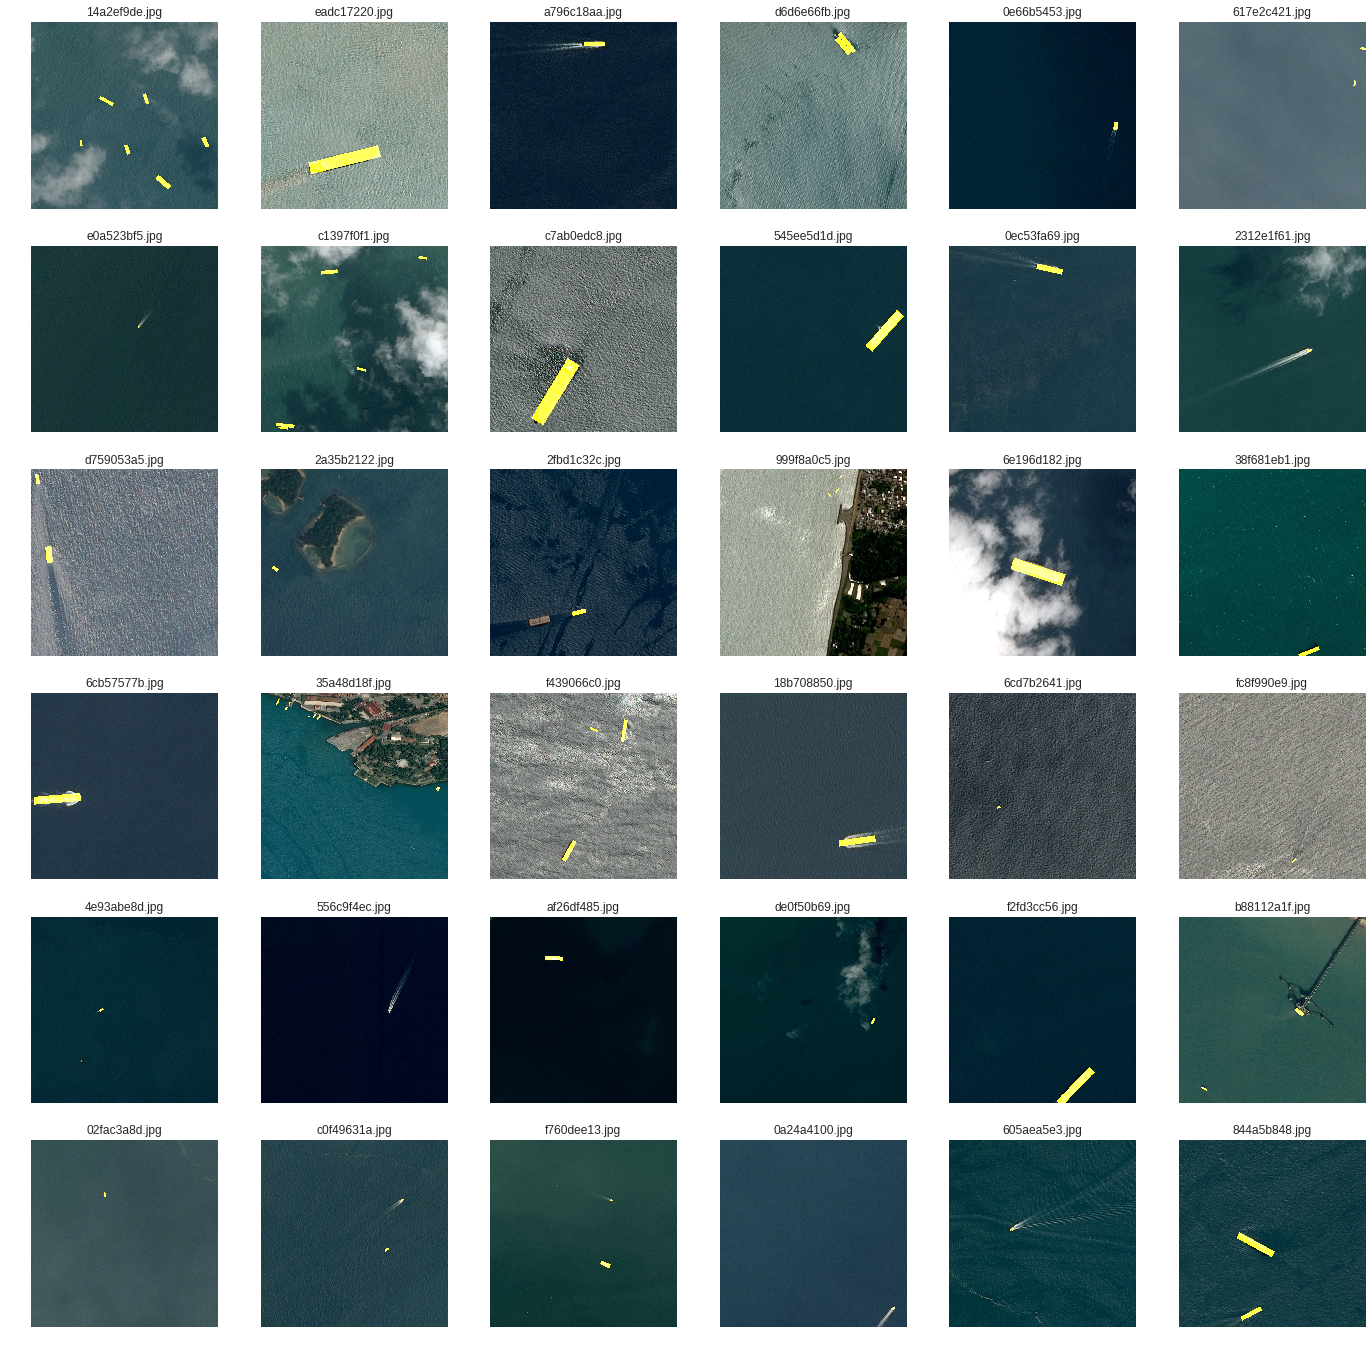

In [0]:
w = 6
h = 6

_, axes_list = plt.subplots(h, w, figsize=(4*w, 4*h))

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        row_index = np.random.randint(len(df)) # take a random row from the df
        ax.imshow(apply_mask(load_img(df.loc[row_index, 'ImageId'])[...,[2,1,0]], rle_to_pixels(df.loc[row_index, 'EncodedPixels'])))
        ax.set_title(df.loc[row_index, 'ImageId'])

**Визуализируем распределение снимков есть корабль/нет корабля**

((42556,), (150000,))

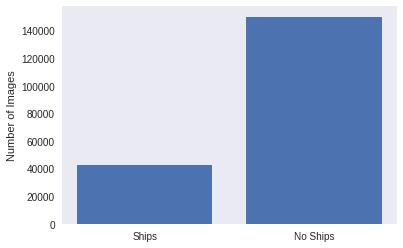

In [0]:
ships = train_df[~train_df['EncodedPixels'].isna()]['ImageId'].unique()
noships = train_df[train_df['EncodedPixels'].isna()]['ImageId'].unique()

plt.bar(['Ships', 'No Ships'], [len(ships), len(noships)]);
plt.ylabel('Number of Images');
ships.shape,noships.shape

**Отрисуем  график  распределения количества кораблей на одной фотографии**

----

Определим 2 функции load_df() и show_df().Первая загружает csv в pandas.DataFrame cоздавая 2 столбца **HasShip** и **TotalShips** из столбца **EncodedPixels**  загруженного csv файла.Вторая отображает количество изображений с кораблями и без них а так же распределение общего количества кораблей на изображении.


In [0]:
def load_df(file="train"):
    """
    Loads a csv, creates the fields `HasShip` and `TotalShips` dropping `EncodedPixels` and setting `ImageId` as index.
    """
    df = pd.read_csv("train_ship_segmentations_v2.csv")
    df['HasShip'] = df['EncodedPixels'].notnull()
    df = df.groupby("ImageId").agg({'HasShip': ['first', 'sum']}) # подсчитывает количество кораблей на изображение, устанавливает ImageId в качестве индекса
    df.columns = ['HasShip', 'TotalShips']
    return df

def show_df(df):
    """
    Prints and displays the ship/no-ship ratio and the ship count distribution of df
    """
    total = len(df)
    ship = df['HasShip'].sum()
    no_ship = total - ship
    total_ships = int(df['TotalShips'].sum())
        
    print(f"Images: {total} \nShips:  {total_ships}")
    print(f"Images with ships:    {round(ship/total,2)} ({ship})")
    print(f"Images with no ships: {round(no_ship/total,2)} ({no_ship})")
    print('------------------------------------')
    
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 6), gridspec_kw = {'width_ratios':[1, 3]});
    
    # Plot ship/no-ship with a bar plot
    ship_ratio = df['HasShip'].value_counts() / total
    ship_ratio = ship_ratio.rename(index={True: 'Ship', False: 'No Ship'})
    ship_ratio.plot.bar(ax=axes[0], color=['red', 'lime'], rot=0, title="Ship/No-ship distribution");
    
    # Plot TotalShips distribution with a bar plot
    total_ships_distribution = df.loc[df['HasShip'], 'TotalShips'].value_counts().sort_index() / ship
    total_ships_distribution.plot(kind='bar', ax=axes[1], rot=0, title="Total ships distribution");
    plt.show()

Images: 192556 
Ships:  81723
Images with ships:    0.22 (42556)
Images with no ships: 0.78 (150000)
------------------------------------


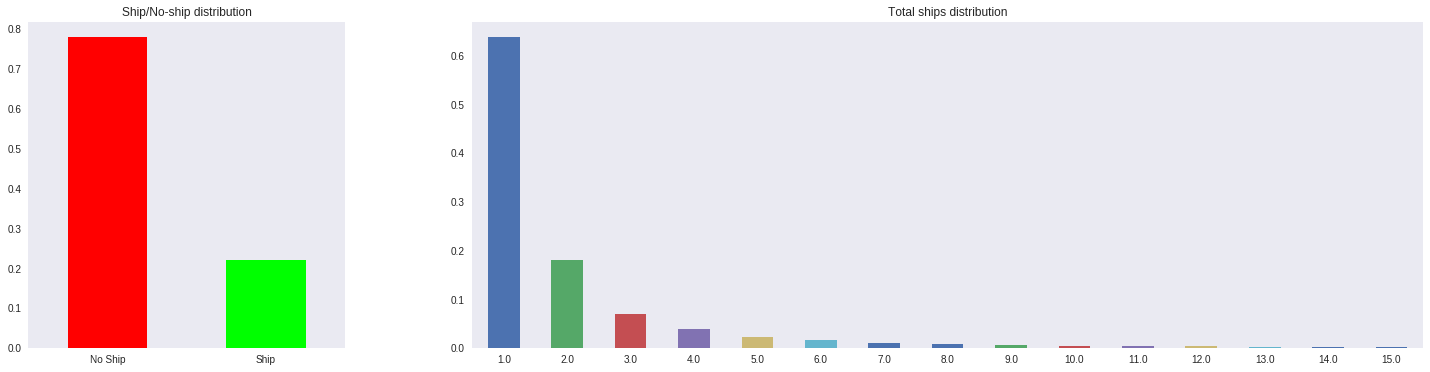

In [0]:
df_train = load_df("train")
show_df(df_train)

Примерно на 22% от общего кол-во тренировочных изображений присутствует хотя бы 1 корабль, преобладающая часть снимков содержит всего 1 корабль но есть и такие на которых изображено 15 кораблей.

**Отрисуем снимок и его маску,затем создадим по  маске boudung box**

In [0]:
## Функция декодирует rle в маску изображение
def rle_decode(mask_rle, shape=(768, 768, 1)):
    '''
    mask_rle: как форматируеться длина закодированой строки (начальная длина)
    shape: (висота,ширина) масива для возрата 
    Возращает numpy масив, 1 - маска, 0 - задний фон
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape).T 
    return img


In [0]:

plt.rcParams['figure.figsize'] = [8.0, 8.0]

In [0]:
ImageId = '002fdcf51.jpg'
img = cv2.imread('train/{}'.format(ImageId))
segments_samples = pd.read_csv("train_ship_segmentations_v2.csv", index_col="ImageId")


***Вначале снимок***

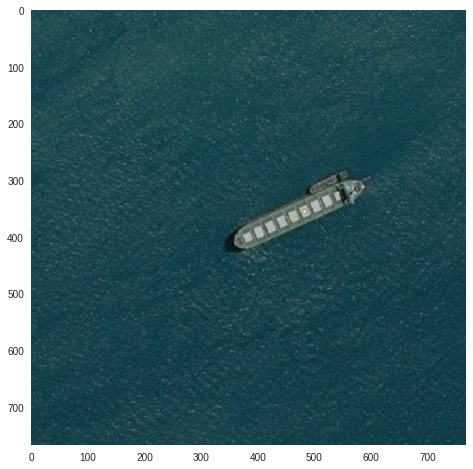

In [0]:
plt.imshow(img[...,[2,1,0]])
plt.show()

***Теперь его маску***

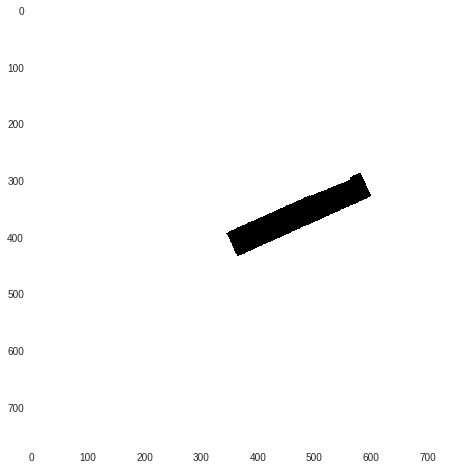

In [0]:
rle_mask = segments_samples['EncodedPixels'][ImageId].tolist()[1]
mask = rle_decode(rle_mask, (768, 768))
plt.imshow(mask)
plt.show()


**Bounding box** 

---


Закодируем этот корабль в bouding box с x, y, шириной, высотой:

x:345, y:287, width:256, height:148


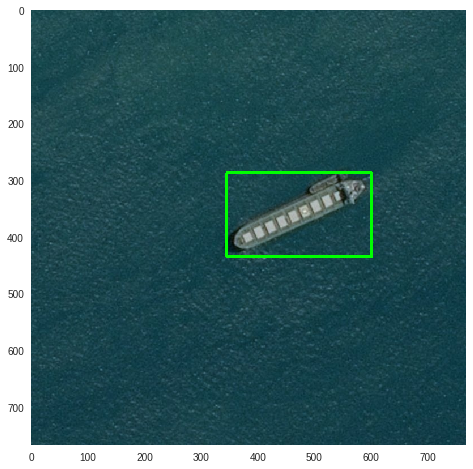

In [0]:
x, y, w, h = cv2.boundingRect(mask)
rect1 = cv2.rectangle(img.copy(),(x,y),(x+w,y+h),(0,255,0),3) 
print("x:{0}, y:{1}, width:{2}, height:{3}".format(x, y, w, h))
plt.imshow(rect1[...,[2,1,0]])
plt.show()

In [0]:
## Уточняем координаты для bouding box
_,contours,_ = cv2.findContours(mask.copy(), 1, 1) 
rect = cv2.minAreaRect(contours[0]) 
(x,y),(w,h), a = rect # угол

**Визуализируем получившийся bouding box**

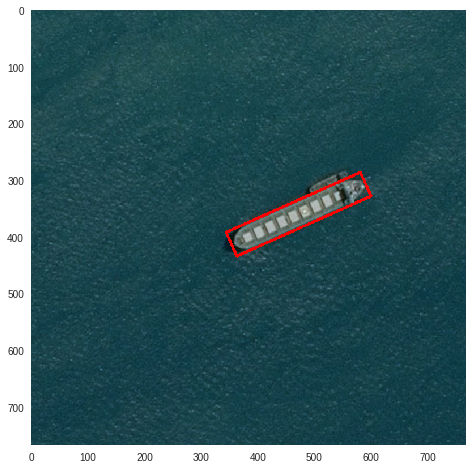

In [0]:
box = cv2.boxPoints(rect)
box = np.int0(box) #перевод в целочисленный формат
rect2 = cv2.drawContours(img.copy(),[box],0,(0,0,255),3)

plt.imshow(rect2[...,[2,1,0]])
plt.show()